In [1]:
# Krishna Thiyagarajan
# Abhinav Jain
# Oct. 09, 2016
# ECE-411: Statistical Learning
# Professor Sam Keene

# Description:
# Takes training data from an experiment to learn
# to predict whether a given protein structure will
# help form RNA and then uses more data from same experiment
# to predict whether or not it will using a self-designed 
# Stochastic Gradient Descent method
#

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import *
from math import *

In [2]:
learningSet = pd.read_csv("input/cod-rna.csv")
testingSet = pd.read_csv("input/cod-rna-test.csv")
print("Learning set dimensions:", learningSet.shape)
print("Testing set dimensions:", testingSet.shape)

Learning set dimensions: (59535, 9)
Testing set dimensions: (271617, 9)


In [3]:
learningSet.head()

,data1,data2,data3,data4,data5,data6,data7,data8,state
0,-766,128,0.140625,0.304688,0.234375,0.140625,0.304688,0.234375,0
1,-726,131,0.129771,0.328244,0.229008,0.129771,0.328244,0.229008,0
2,-648,123,0.146341,0.333333,0.211382,0.146341,0.333333,0.211382,0
3,-764,124,0.137097,0.322581,0.233871,0.137097,0.322581,0.233871,0
4,-584,130,0.153846,0.392308,0.184615,0.153846,0.392308,0.184615,0


In [4]:
testingSet.head()

,data1,data2,data3,data4,data5,data6,data7,data8,state
0,-500,128,0.140625,0.304688,0.234375,0.129771,0.328244,0.229008,0
1,-541,123,0.140625,0.304688,0.234375,0.146341,0.333333,0.211382,0
2,-479,124,0.140625,0.304688,0.234375,0.137097,0.322581,0.233871,0
3,-427,128,0.140625,0.304688,0.234375,0.153846,0.392308,0.184615,0
4,-478,120,0.140625,0.304688,0.234375,0.250000,0.216667,0.275000,0


In [5]:
learningSet = (learningSet - learningSet.mean()) / (learningSet.max() - learningSet.min()) #Normalizes data
testingSet = (testingSet - testingSet.mean()) / (testingSet.max() - testingSet.min())
learingSet = learningSet.iloc[np.random.permutation(len(learningSet))] #Randomizes data order
testingSet = testingSet.iloc[np.random.permutation(len(testingSet))]

for index, row in learningSet.iterrows(): # Switches normalized output values to originals for learning set
    if row['state'] < 0: #Less than 0 means 0
        row['state'] = 0;
    elif row['state'] > 0: # Greater than 0 means 1 (Normalization messes up the values a bit)
        row['state'] = 1;
        
for index, row in testingSet.iterrows(): # Does the same for testing set
    if row['state'] < 0:
        row['state'] = 0;
    elif row['state'] > 0:
        row['state'] = 1;

In [6]:
learningSet.head()

,data1,data2,data3,data4,data5,data6,data7,data8,state
0,-0.162755,0.475106,-0.216824,0.261881,-0.104125,-0.219759,0.267075,-0.110266,0.0
1,-0.141342,0.520561,-0.245876,0.337237,-0.123417,-0.248811,0.342430,-0.129558,0.0
2,-0.099586,0.399349,-0.201525,0.353517,-0.186773,-0.204460,0.358710,-0.192914,0.0
3,-0.161685,0.414500,-0.226267,0.319121,-0.105937,-0.229202,0.324314,-0.112078,0.0
4,-0.065325,0.505409,-0.181437,0.542178,-0.282987,-0.184372,0.547371,-0.289127,0.0


In [7]:
testingSet.head()

,data1,data2,data3,data4,data5,data6,data7,data8,state
130517,0.102912,-0.271817,0.042524,-0.002150,-0.094167,-0.135595,-0.011441,0.039605,0.0
240605,0.061033,-0.287442,0.265104,0.348617,-0.322448,-0.156226,0.042631,0.020648,1.0
59055,-0.003483,0.384433,-0.006605,0.008109,-0.009114,-0.052685,-0.005210,0.083724,0.0
104680,-0.169867,0.384433,-0.047013,-0.094182,0.120668,0.049767,0.063019,-0.083308,1.0
112217,-0.248531,0.415683,-0.056087,0.002060,0.013038,0.028900,-0.194107,0.120571,1.0


In [8]:
classLearn = learningSet["state"].as_matrix().transpose() #Transposes output in order to manipulate stuff
inputsLearn = learningSet.drop("state", 1).as_matrix().transpose() #Ditto as above
inputsLearn = np.append(np.ones((1,59535)), inputsLearn, axis = 0) # Appends a single column for beta_0

# Ditto as above except for testingSet
classTest = testingSet["state"].as_matrix().transpose() # 
inputsTest = testingSet.drop("state", 1).as_matrix().transpose()
inputsTest = np.append(np.ones((1,271617)), inputsTest, axis = 0)

In [9]:
weights = []

def sigmoid(x):
    return (1.0/(1.0+np.exp(-x))); 

def logLikely(x,y,w): # log likelihood function
    item = np.dot(np.transpose(w),x); 
    result = y*log(sigmoid(item))+(1-y)*log(1.0-(sigmoid(item)))
    return result

def SGD(y,X,a): #SGD algorithm
    #Calculates num of iterations and attributes
    numberOfTrials = y.shape[0] 
    numberOfEstimators = X.shape[0]
    #Intializes variables
    prevWeight = np.ones(numberOfEstimators)
    weight = np.zeros(numberOfEstimators)
    error = 10000.0
    prevCost = 1000.0
    currCost = 0
    
    #Loops through to find a minimum error point
    while ((prevCost < currCost) or (abs(prevCost - currCost) > 1e-10)):
        currCost = 0.0
        while (np.linalg.norm(prevWeight-weight,ord=2) > 1e-6):
            prevWeight = weight #init prev. weight
            i = randint(1,59534) #Generates random integer for selecting point
            grad = (y[i] - sigmoid(np.dot(np.transpose(prevWeight),X[:,i]))) #Estimates gradient
            weight = prevWeight + a * grad * X[:,i] #Uses formula given in class to move towards minimum
            currCost += logLikely(X[:,i],y[i],weight) #Changes cost
            weights.append(np.linalg.norm(weight,ord=2)) #Adds weight to array of weights
        prevCost = currCost
    return weight #returns

def predict(inputVector,estimatorVector):
    t = estimatorVector
    x = inputVector
    confidence = sigmoid(np.dot(np.transpose(t) , x))
    if confidence > 0.5:
        return 1
    else:
        return 0

In [10]:
outputWeights = SGD(classLearn,inputsLearn,1.0/200.0)
print("Weights =", outputWeights)

Weights = [ -0.90750739 -19.56018889  -3.72679465   1.6101682    1.32174417
  -0.9893801    1.89304649   1.10648818  -0.82599035]


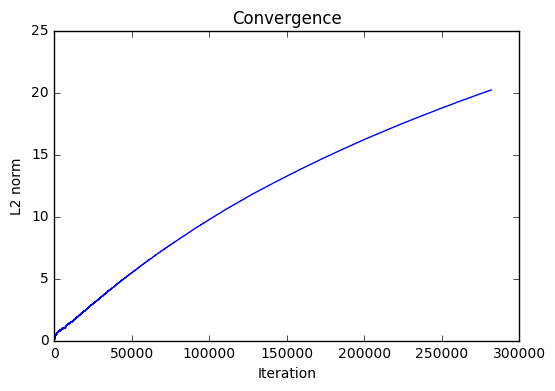

In [11]:
x = []
for i in range(len(weights)):
    x.append(i)
plt.plot(x,weights)
plt.title("Convergence")
plt.xlabel("Iteration")
plt.ylabel("L2 norm")
plt.show()

In [26]:
hits = 0
misses = 0
total = 0
#Calculates hits and misses on the test dataset
for j in range(271617):
    if (classTest[j] == predict(inputsTest[:,j],outputWeights)):
        hits += 1
    else:
        misses += 1
    total += 1
print ("Hits:", hits,"\nMisses:",  misses,"\nTotal:", total, "\nHit %:","%d%s" % (100*hits/total , "%") )

Hits: 252058 
Misses: 19559 
Total: 271617 
Hit %: 92%
